In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.solvers.sde import Euler
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.stochastic_processes.cell_model import CellDiffusionProcess, CellDiffusionProcessAux
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess
from mixedbridge.mcmc.pcn import PreconditionedCrankNicolson

In [3]:
dim = 2
alpha = 1. / 16.
sigma = .1
T = 4.0
dt = 1./500
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)

In [4]:
wiener_process = WienerProcess(dim, dtype, T=T, dt=dt)
sde = CellDiffusionProcess(alpha, sigma, T=T, dt=dt)
solver = Euler(sde, wiener_process)

n_batches = 100
path = solver.solve(x0, dWs=None, rng_key=rng_key, n_batches=n_batches)

Text(0.5, 1.0, 'Unconditional process')

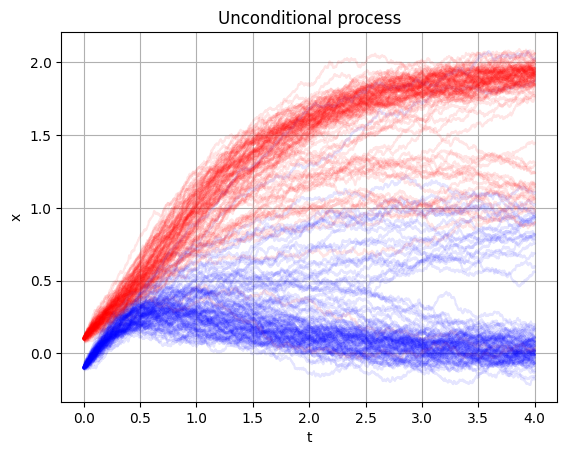

In [5]:
for i in range(n_batches):
    plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.title("Unconditional process")

In [6]:
print(path)

 sample path contains 100 samples，each sample runs 2000 steps:
 xs.shape: (100, 2000, 2)
 ts.shape: (2000,)
 log_likelihood.shape: (100,)


In [7]:
aux_sde = CellDiffusionProcessAux(alpha, sigma, T=4.0, dt=1./500.)
L0 = jnp.eye(dim, dtype=dtype)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
# xT = jnp.array([2.0, -0.1], dtype=dtype)
xT = jnp.array([1.0, -0.1], dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
guided_sde = GuidedBridgeProcess(sde, aux_sde, L0, Sigma0, start=x0, target=xT)
solver = Euler(guided_sde, wiener_process)
path = solver.solve(x0, dWs=None, rng_key=rng_key, log_likelihood=True, n_batches=n_batches)

Text(0.5, 1.0, 'Guided process')

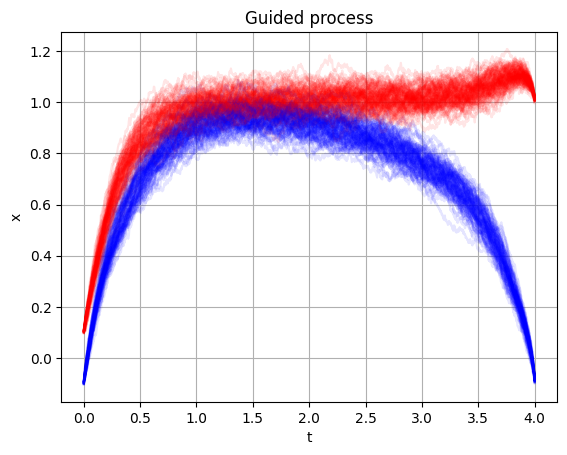

In [8]:
for i in range(n_batches):
    plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.title("Guided process")

In [9]:
print(path)

 sample path contains 100 samples，each sample runs 2000 steps:
 xs.shape: (100, 2000, 2)
 ts.shape: (2000,)
 log_likelihood.shape: (100,)


In [10]:
mcmc_model_faster = PreconditionedCrankNicolson(
    rho=0.98,
    x0=x0,
    guided_process=guided_sde,
    rng_key=jax.random.PRNGKey(42),
    n_batches=10
)
path_mcmc_faster, lls_faster = mcmc_model_faster.update(n_iters=5000, verbose=True, log_every=100)

Iteration 1/5000: log likelihood = 20.17985725402832
Iteration 101/5000: log likelihood = 26.14103126525879
Iteration 201/5000: log likelihood = 23.52778434753418
Iteration 301/5000: log likelihood = 30.392562866210938
Iteration 401/5000: log likelihood = 29.96124839782715
Iteration 501/5000: log likelihood = 31.004568099975586
Iteration 601/5000: log likelihood = 30.847314834594727
Iteration 701/5000: log likelihood = 30.294355392456055
Iteration 801/5000: log likelihood = 29.495107650756836
Iteration 901/5000: log likelihood = 31.862497329711914
Iteration 1001/5000: log likelihood = 34.856300354003906
Iteration 1101/5000: log likelihood = 31.950382232666016
Iteration 1201/5000: log likelihood = 31.214826583862305
Iteration 1301/5000: log likelihood = 30.830829620361328
Iteration 1401/5000: log likelihood = 31.425466537475586
Iteration 1501/5000: log likelihood = 27.418787002563477
Iteration 1601/5000: log likelihood = 32.50149154663086
Iteration 1701/5000: log likelihood = 26.4510250

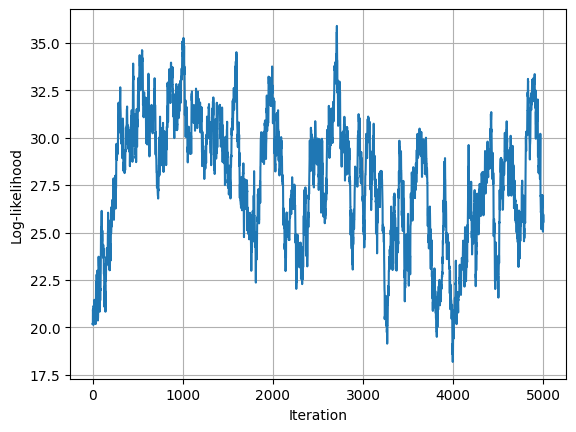

In [11]:
plt.plot(lls_faster)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.grid()
# plt.savefig('./cell_mcmc_lls.png', dpi=150, bbox_inches='tight')

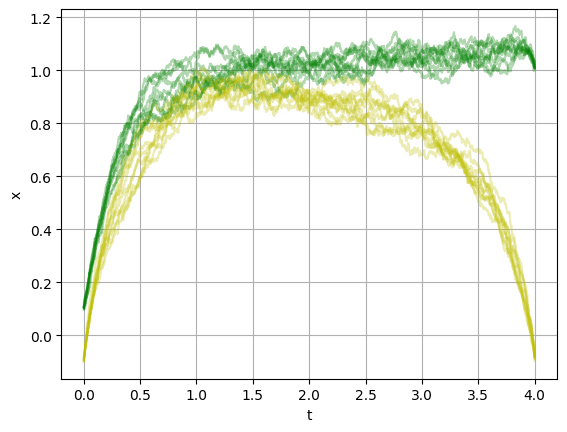

In [12]:
for i in range(10):
    # plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    # plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
    plt.plot(path_mcmc_faster.ts, path_mcmc_faster.xs[i, :, 0], color='g', alpha=0.3)
    plt.plot(path_mcmc_faster.ts, path_mcmc_faster.xs[i, :, 1], color='y', alpha=0.3)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
# plt.savefig('./cell_mcmc_sample.png', dpi=150, bbox_inches='tight')